# YOLOv8 Görüntü Bölütleme

## Ortam Hazırlığı

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/YOLOv8/4_image_segmentation

/content/drive/MyDrive/YOLOv8/4_image_segmentation


In [3]:
%pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.184 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


##Test / Prediction

In [ ]:
!yolo segment predict model=yolov8x-seg.pt source='https://ultralytics.com/images/bus.jpg'

100% 137M/137M [00:01<00:00, 118MB/s]
Ultralytics YOLOv8.0.183 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8x-seg summary (fused): 295 layers, 71797696 parameters, 0 gradients

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/drive/MyDrive/YOLOv8/4_image_segmentation/bus.jpg: 640x480 5 persons, 1 bicycle, 1 bus, 1 tie, 4532.5ms
Speed: 4.5ms preprocess, 4532.5ms inference, 27.3ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


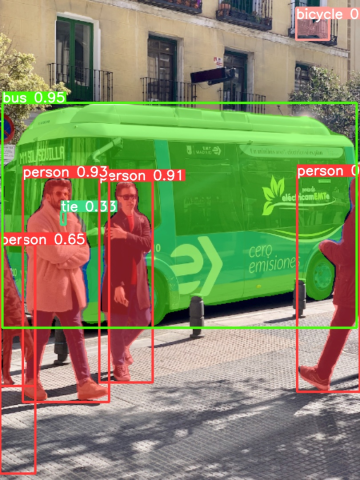

In [ ]:
import cv2
import imutils
from google.colab.patches import cv2_imshow

image_path = "runs/segment/predict2/bus.jpg"

img = cv2.imread(image_path)
img = imutils.resize(img, width=360)
cv2_imshow(img)

## Python Uygulaması // Implementation

In [ ]:
import cv2
import imutils
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [ ]:
### data extraction block ###

def extract_data(img, model):
  h, w, ch = img.shape
  results = model.predict(source=img.copy(), save=False, save_txt=False)
  result = results[0]
  seg_contour_idx = []

  for seg in result.masks.segments:
    seg[:,0] = seg[:,0] * w
    seg[:,1] = seg[:,1] * h
    segment = np.array(seg, dtype=np.int32)
    seg_contour_idx.append(segment)

  bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
  class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
  scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)

  return bboxes, class_ids, seg_contour_idx, scores

##############################


0: 640x480 4 persons, 1 bus, 1 skateboard, 542.5ms
Speed: 4.7ms preprocess, 542.5ms inference, 27.4ms postprocess per image at shape (1, 3, 640, 480)
WARNING ⚠️ 'Masks.segments' is deprecated. Use 'Masks.xyn' for segments (normalized) and 'Masks.xy' for segments (pixels) instead.


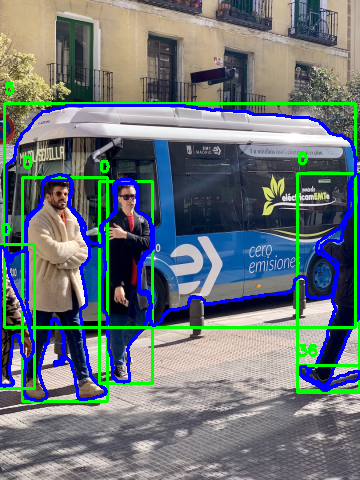

In [ ]:
img_path = "bus.jpg"
model_path = "yolov8n-seg.pt"
font = cv2.FONT_HERSHEY_SIMPLEX

img = cv2.imread(img_path)
img = imutils.resize(img, width=360)

model = YOLO(model_path)

# data extraction
bboxes, class_ids, seg_contour_idx, scores = extract_data(img, model)


for box, class_id, segmentation_id, score in zip(bboxes, class_ids, seg_contour_idx, scores):
  (xmin, ymin, xmax, ymax) = box

  cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  cv2.polylines(img, [segmentation_id], True, (255,0,0), 2)
  cv2.putText(img, str(class_id), (xmin, ymin-10), font, 0.5, (0,255,0), 2)

cv2_imshow(img)

# ödev 1: indekslere ait sınıflara eriş
# ödev 2: güven skorlarına eriş ve cv2.putText ile yazdır
# ödev 3: maskeleme işlemini yap: cv2.fillPoly()

## Eğitim // Training

In [4]:
!unzip data/car_part_dataset.zip -d data

Archive:  data/car_part_dataset.zip
   creating: data/car_part_dataset/images/
   creating: data/car_part_dataset/images/test/
  inflating: data/car_part_dataset/images/test/1003.jpg  
  inflating: data/car_part_dataset/images/test/1008.jpg  
  inflating: data/car_part_dataset/images/test/1009.jpg  
  inflating: data/car_part_dataset/images/test/1012.jpg  
  inflating: data/car_part_dataset/images/test/1015.jpg  
  inflating: data/car_part_dataset/images/test/1022.jpg  
  inflating: data/car_part_dataset/images/test/1034.jpg  
  inflating: data/car_part_dataset/images/test/1036.jpg  
  inflating: data/car_part_dataset/images/test/1037.jpg  
  inflating: data/car_part_dataset/images/test/1049.jpg  
  inflating: data/car_part_dataset/images/test/105.jpg  
  inflating: data/car_part_dataset/images/test/1062.jpg  
  inflating: data/car_part_dataset/images/test/1066.jpg  
  inflating: data/car_part_dataset/images/test/1071.jpg  
  inflating: data/car_part_dataset/images/test/1083.jpg  
  in

In [5]:
!yolo segment train data=data/config.yaml model=yolov8n-seg.pt epochs=20 imgsz=640 workers=8 batch=8 device=0 name=yolov8_car_part_segmentation

Ultralytics YOLOv8.0.184 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data/config.yaml, epochs=20, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8_car_part_segmentation, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, ker

In [ ]:
# !yolo segment train model="..../last.pt" resume=True

##Test // Prediction

In [6]:
!yolo segment predict model=runs/segment/yolov8_car_part_segmentation/weights/best.pt source='data/car_part_dataset/images/test' save=True

Ultralytics YOLOv8.0.184 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients

image 1/176 /content/drive/MyDrive/YOLOv8/4_image_segmentation/data/car_part_dataset/images/test/1003.jpg: 640x640 1 back_bumper, 1 back_glass, 2 back_lights, 13.7ms
image 2/176 /content/drive/MyDrive/YOLOv8/4_image_segmentation/data/car_part_dataset/images/test/1008.jpg: 640x640 1 front_bumper, 1 front_glass, 2 front_lights, 1 hood, 25.4ms
image 3/176 /content/drive/MyDrive/YOLOv8/4_image_segmentation/data/car_part_dataset/images/test/1009.jpg: 640x640 1 back_bumper, 1 back_door, 1 back_glass, 1 back_light, 1 front_door, 19.7ms
image 4/176 /content/drive/MyDrive/YOLOv8/4_image_segmentation/data/car_part_dataset/images/test/1012.jpg: 640x640 1 back_bumper, 1 back_glass, 2 back_lights, 9.4ms
image 5/176 /content/drive/MyDrive/YOLOv8/4_image_segmentation/data/car_part_dataset/images/test/1015.jpg: 640x640 1 back_bumper, 1 back_g

In [9]:
import cv2
import imutils
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [10]:
### data extraction block ###

def extract_data(img, model):
  h, w, ch = img.shape
  results = model.predict(source=img.copy(), save=False, save_txt=False)
  result = results[0]
  seg_contour_idx = []

  for seg in result.masks.segments:
    seg[:,0] = seg[:,0] * w
    seg[:,1] = seg[:,1] * h
    segment = np.array(seg, dtype=np.int32)
    seg_contour_idx.append(segment)

  bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
  class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
  scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)
  class_names = result.names

  return bboxes, class_ids, seg_contour_idx, scores, class_names

##############################


0: 384x640 1 back_door, 1 front_bumper, 1 front_door, 1 front_glass, 2 front_lights, 1 hood, 20.6ms
Speed: 2.2ms preprocess, 20.6ms inference, 10.9ms postprocess per image at shape (1, 3, 384, 640)
WARNING ⚠️ 'Masks.segments' is deprecated. Use 'Masks.xyn' for segments (normalized) and 'Masks.xy' for segments (pixels) instead.


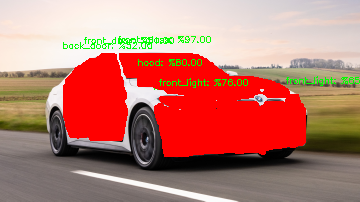

In [13]:
img_path = "inference/test.jpg"
model_path = "runs/segment/yolov8_car_part_segmentation/weights/best.pt"
font = cv2.FONT_HERSHEY_SIMPLEX

img = cv2.imread(img_path)
img = imutils.resize(img, width=360)

model = YOLO(model_path)

# data extraction
bboxes, class_ids, seg_contour_idx, scores, class_names = extract_data(img, model)


for box, class_id, segmentation_id, score in zip(bboxes, class_ids, seg_contour_idx, scores):
  (xmin, ymin, xmax, ymax) = box

  # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  # cv2.polylines(img, [segmentation_id], True, (255,0,0), 2)
  cv2.fillPoly(img, pts=[segmentation_id], color=((0,0,255)))

  class_name = class_names[class_id]
  score = score * 100
  text = f"{class_name}: %{score:.2f}"

  cv2.putText(img, str(text), (xmin, ymin-10), font, 0.3, (0,255,0), 1)

cv2_imshow(img)

# Ödev: Her sınıf için farklı bir renk ile çizim:
# ----------------------------------------------
# 1. Adım: Sınıf sayısını bul: len()
# 2. Adım: Her sınıf için farklı renk üret: random kütüphanesi --> (0,255)
# 3. Adım: Çizimi yap.